In [56]:
# ==========================================
# 1. System & Utilities (System Operations)
# ==========================================
import os
import cv2
import itertools

# ==========================================
# 2. Data Handling (Data Manipulation)
# ==========================================
import numpy as np
import pandas as pd

# ==========================================
# 3. Visualization (Plotting Graphs)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 4. Machine Learning & Metrics (Scikit-Learn)
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ==========================================
# 5. Deep Learning - Core (TensorFlow)
# ==========================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================================
# 6. Deep Learning - Models & Layers
# ==========================================
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization)
from tensorflow.keras.applications import MobileNetV2

# ==========================================
# 7. Deep Learning - Callbacks (Training Control)
# ==========================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Success Message
print("✅ Libraries Imported Successfully!")

Libraries Imported Successfully!


In [65]:
DATASET_PATH = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset'
train_path = os.path.join(DATASET_PATH, "train")
test_path = os.path.join(DATASET_PATH, "test")
print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Test path exists: {os.path.exists(test_path)}")

Train path exists: True
Test path exists: True


Number of images per class: {'benign': 5000, 'malignant': 4605}


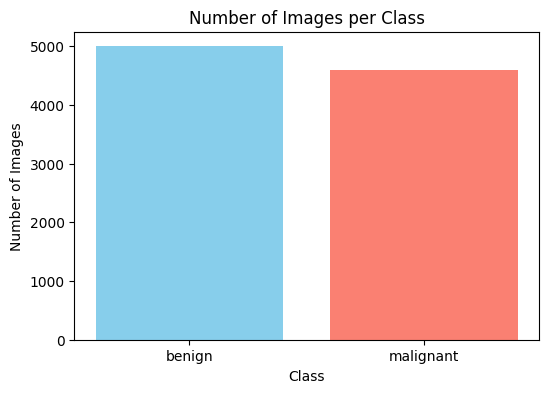

In [4]:

# Get class names (folder names) in the training directory
classes = os.listdir(train_path)  # e.g., ['benign', 'malignant']

# Count the number of images in each class
image_counts = {}
for c in classes:
    class_path = os.path.join(train_path, c)
    image_counts[c] = len(os.listdir(class_path))  # Count files in the folder

# Print the number of images per class
print("Number of images per class:", image_counts)

# Plot a bar chart to visualize the distribution of images per class
plt.figure(figsize=(6,4))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'salmon'])
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()



In [5]:

img_size = (224,224)
batch_size = 32

# --- Data Augmentation + Rescaling for training ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

# --- Training Generator ---
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',     
    shuffle=True
)

# --- Validation Generator ---
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',    
    shuffle=False
)


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


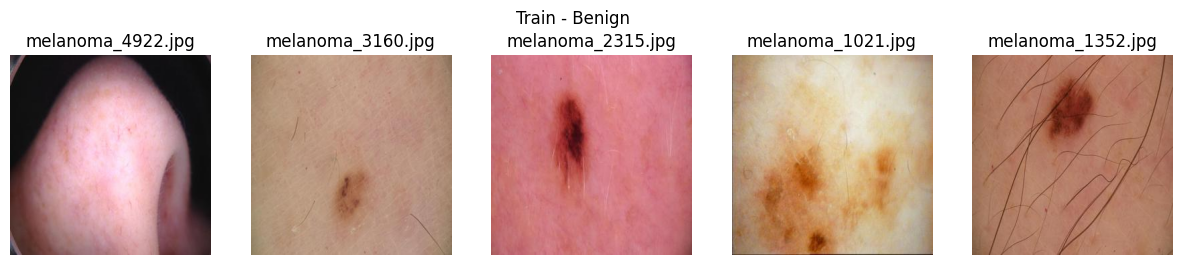

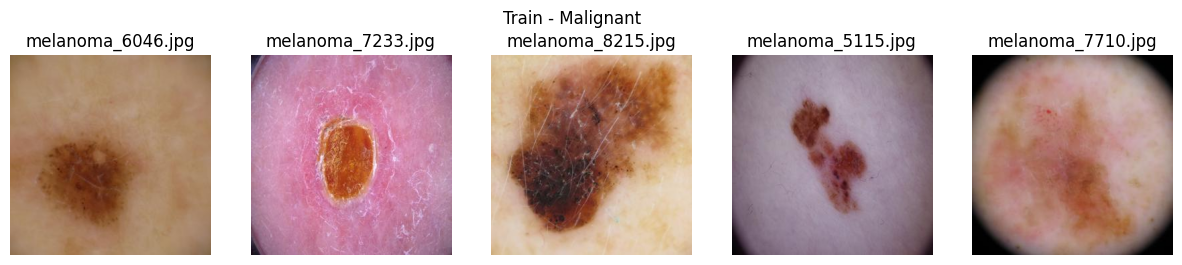

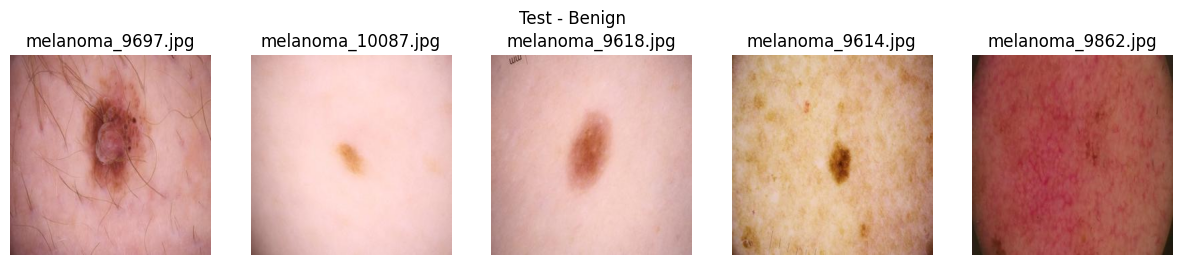

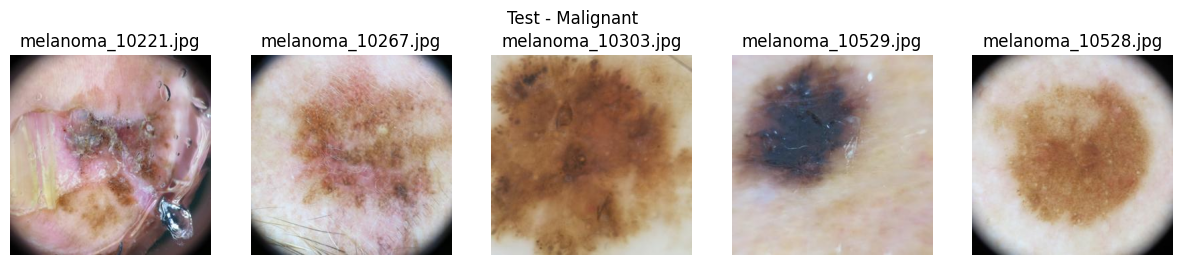

In [6]:
# Show Samples From each class
def show_sample_images(folder_path, title, n=5):
  
    if not os.path.exists(folder_path):
        print(f"Directory not found: {folder_path}")
        return

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:n]

    plt.figure(figsize=(15, 3))
    for i, f in enumerate(files):
        img_path = os.path.join(folder_path, f)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# SHOW SAMPLES

folders = [
    (os.path.join(train_path, "benign"), "Train - Benign"),
    (os.path.join(train_path, "malignant"), "Train - Malignant"),
    (os.path.join(test_path, "benign"), "Test - Benign"),
    (os.path.join(test_path, "malignant"), "Test - Malignant"),
]

for folder_path, title in folders:
    show_sample_images(folder_path, title, n=5)

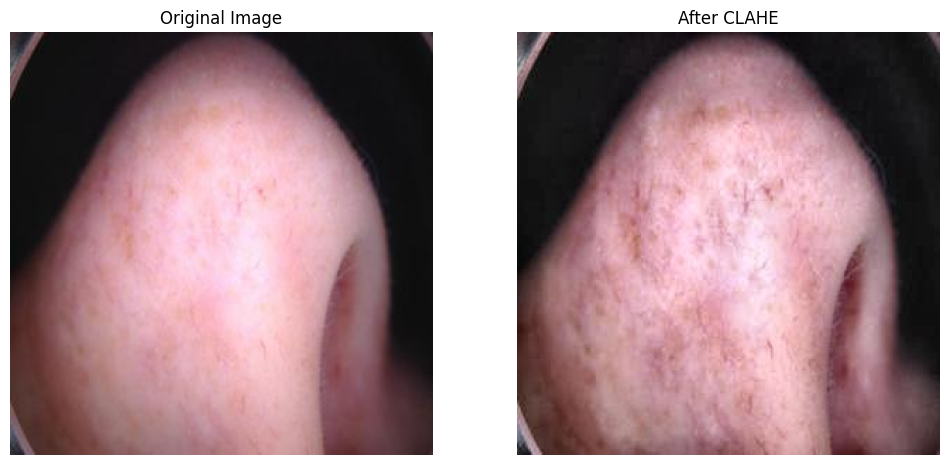

In [7]:
# Histogram Equalization / CLAHE Algorithm Definition
def apply_clahe(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img

# Show Difference
folder_benign_train = os.path.join(train_path, "benign")


if len(os.listdir(folder_benign_train)) > 0:
    img_name = os.listdir(folder_benign_train)[0]  
    img_path_clahe_test = os.path.join(folder_benign_train, img_name)
    img_org = cv2.imread(img_path_clahe_test)
    img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

    img_clahe = apply_clahe(img_org)

   
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_org)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img_clahe)
    plt.axis('off')
    plt.title("After CLAHE")
    plt.show()
else:
    print("No images found to test CLAHE.")

_____________________________________________________________________________________________________________________________________________

# =====================================================
# 2. EXPERIMENT 1 - MODEL (Vanella CNN).
# =====================================================

In [9]:

# Initialize the Sequential model
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(224, 224, 3))) #input layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Reduces spatial dimensions by half (downsampling)

# --- Block 2: Mid-Level Features ---
# Increasing filters to 64 to capture more complex patterns.
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25)) # Dropout drops 25% of neurons randomly to prevent overfitting

# --- Block 3: High-Level Features ---
# Increasing filters to 128.
model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.3)) # Increased dropout rate as the model gets deeper

# --- Block 4: Very Complex Features (Added for higher accuracy) ---
# 256 filters to capture the most abstract features of the skin lesion.
model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.3)) # Higher dropout to strongly combat overfitting in deep layers

# --- Classification Head ---
model.add(tf.keras.layers.Flatten()) # Converts the 3D feature maps into a 1D vector

# Fully connected layer for decision making
model.add(tf.keras.layers.Dense(256, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.5)) # 50% dropout in the dense layer is standard practice

# Output Layer

# Sigmoid activation is used because we have a binary classification task (0 or 1)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',  # Standard loss function for binary classification tasks
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Using Adam optimizer with a low initial learning rate for stability
    metrics=['accuracy']         # Tracking accuracy during training
)

# Display the model structure
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,985 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# --- 2. Setup Callbacks (Training Helpers) ---

# ModelCheckpoint: Saves the best version of the model based on validation accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint( # Changed to tf.keras.callbacks.ModelCheckpoint
    'best_vanilla_model.h5',     # Filename to save the best model
    monitor='val_accuracy',      # Metric to monitor
    save_best_only=True,         # Only save if the current model is better than previous best
    mode='max',                  # We want to maximize accuracy
    verbose=1
)

# EarlyStopping: Stops training if validation loss doesn't improve for a set number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping( # Changed to tf.keras.callbacks.EarlyStopping
    monitor='val_loss',          # Metric to monitor for stopping
    patience=5,                 # Number of epochs to wait before stopping
    restore_best_weights=True,   # Restore model weights to the best epoch found
    verbose=1
)

# ReduceLROnPlateau: Reduces learning rate if validation loss plateaus (stops improving).
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( # Changed to tf.keras.callbacks.ReduceLROnPlateau
    monitor='val_loss',
    factor=0.2,                  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,                  # Number of epochs to wait before reducing LR
    min_lr=0.00001,              # Lower bound for the learning rate
    verbose=1
)
# Combine callbacks into a list
callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [14]:
print("Starting Training...")

history_ex1 = model.fit(
    train_generator,
    epochs=50, 
    validation_data=val_generator,
    callbacks=callbacks_list
)

print("Training Finished.")


Starting Training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1764801187.778133     131 service.cc:148] XLA service 0x7d5ae8005370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764801187.778802     131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764801187.778825     131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764801188.200683     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/241 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.3984 - loss: 0.7068 

I0000 00:00:1764801195.138902     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6576 - loss: 0.5867
Epoch 1: val_accuracy improved from -inf to 0.83030, saving model to best_vanilla_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 177s 698ms/step - accuracy: 0.6580 - loss: 0.5863 - val_accuracy: 0.8303 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8280 - loss: 0.3849
Epoch 2: val_accuracy improved from 0.83030 to 0.86205, saving model to best_vanilla_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 427ms/step - accuracy: 0.8281 - loss: 0.3848 - val_accuracy: 0.8621 - val_loss: 0.4169 - learning_rate: 1.0000e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8641 - loss: 0.3269
Epoch 3: val_accuracy did not improve from 0.86205
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 428ms/step - accuracy: 0.8642 - loss: 0.3268 - val_accuracy: 0.8548 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8794 - loss: 0.2925
Epoch 4: val_accuracy did not improve from 0.86205
241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 431ms/step - accuracy: 0.8794 - loss: 0.2925 - val_accuracy: 0.8605 - val_loss: 0.3786 - learning_rate: 1.0000e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8807 - loss: 0.2852
Epoch 5: val_accuracy did not improve from 0.86205
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.8807 - loss: 0.2852 - val_accuracy: 0.8475 - val_loss: 0.4117 - learning_rate

241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 421ms/step - accuracy: 0.8866 - loss: 0.2835 - val_accuracy: 0.8782 - val_loss: 0.3579 - learning_rate: 1.0000e-04
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8879 - loss: 0.2722
Epoch 7: val_accuracy did not improve from 0.87819
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.8879 - loss: 0.2722 - val_accuracy: 0.8449 - val_loss: 0.4112 - learning_rate: 1.0000e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8832 - loss: 0.2703
Epoch 8: val_accuracy did not improve from 0.87819
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8832 - loss: 0.2702 - val_accuracy: 0.8735 - val_loss: 0.3172 - learning_rate: 1.0000e-04
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8854 - loss: 0.2710
Epoch 9: val_accuracy improved from 0.87819 to 0.89016, saving model to best_vanilla_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 430ms/step - accuracy: 0.8854 - loss: 0.2710 - val_accuracy: 0.8902 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8917 - loss: 0.2608
Epoch 10: val_accuracy did not improve from 0.89016
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 422ms/step - accuracy: 0.8917 - loss: 0.2608 - val_accuracy: 0.8751 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8953 - loss: 0.2468
Epoch 11: val_accuracy did not improve from 0.89016
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 419ms/step - accuracy: 0.8953 - loss: 0.2469 - val_accuracy: 0.8824 - val_loss: 0.3032 - learning_rate: 1.0000e-04
Epoch 12/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8953 - loss: 0.2513
Epoch 12: val_accuracy improved from 0.89016 to 0.89276, saving model to best_vanilla_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 420ms/step - accuracy: 0.8953 - loss: 0.2513 - val_accuracy: 0.8928 - val_loss: 0.2968 - learning_rate: 1.0000e-04
Epoch 13/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8926 - loss: 0.2454
Epoch 13: val_accuracy did not improve from 0.89276
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 421ms/step - accuracy: 0.8926 - loss: 0.2455 - val_accuracy: 0.8881 - val_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 14/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8953 - loss: 0.2393
Epoch 14: val_accuracy did not improve from 0.89276
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 417ms/step - accuracy: 0.8953 - loss: 0.2393 - val_accuracy: 0.8855 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 15/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9042 - loss: 0.2355
Epoch 15: val_accuracy improved from 0.89276 to 0.89797, saving model to best_vanilla_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.9042 - loss: 0.2355 - val_accuracy: 0.8980 - val_loss: 0.2716 - learning_rate: 1.0000e-04
Epoch 16/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8945 - loss: 0.2419
Epoch 16: val_accuracy did not improve from 0.89797
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 423ms/step - accuracy: 0.8945 - loss: 0.2419 - val_accuracy: 0.8824 - val_loss: 0.2823 - learning_rate: 1.0000e-04
Epoch 17/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8989 - loss: 0.2441
Epoch 17: val_accuracy did not improve from 0.89797
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 427ms/step - accuracy: 0.8989 - loss: 0.2441 - val_accuracy: 0.8839 - val_loss: 0.3134 - learning_rate: 1.0000e-04
Epoch 18/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8997 - loss: 0.2362
Epoch 18: val_accuracy did not improve from 0.89797
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 424ms/step - accuracy: 0.8997 - loss: 0.2362 - val_accuracy: 0.8798 - val_loss: 0.3242 - learnin

241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 432ms/step - accuracy: 0.8922 - loss: 0.2432 - val_accuracy: 0.9125 - val_loss: 0.2472 - learning_rate: 1.0000e-04
Epoch 20/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9032 - loss: 0.2333
Epoch 20: val_accuracy did not improve from 0.91255
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 419ms/step - accuracy: 0.9032 - loss: 0.2333 - val_accuracy: 0.9032 - val_loss: 0.2569 - learning_rate: 1.0000e-04
Epoch 21/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9086 - loss: 0.2179
Epoch 21: val_accuracy did not improve from 0.91255
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 421ms/step - accuracy: 0.9086 - loss: 0.2180 - val_accuracy: 0.9120 - val_loss: 0.2683 - learning_rate: 1.0000e-04
Epoch 22/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9039 - loss: 0.2279
Epoch 22: val_accuracy did not improve from 0.91255
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.9039 - loss: 0.2279 - val_accuracy: 0.9084 - val_loss: 0.2641 - learnin

In [20]:
model.save('/kaggle/working/best_vanilla_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [15]:
val_generator.shuffle = False
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(val_loss, val_acc)

61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.9126 - loss: 0.2477
0.24265477061271667 0.9125455617904663


61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step


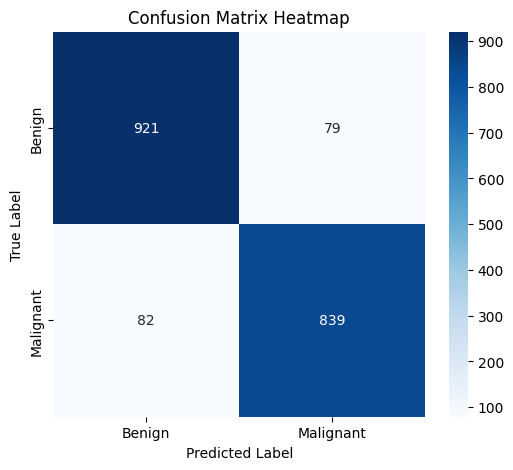

              precision    recall  f1-score   support

      Benign       0.92      0.92      0.92      1000
   Malignant       0.91      0.91      0.91       921

    accuracy                           0.92      1921
   macro avg       0.92      0.92      0.92      1921
weighted avg       0.92      0.92      0.92      1921



In [17]:

# True labels
true_labels = val_generator.classes

# Predicted probabilities
pred_probs = model.predict(val_generator)

# Convert probabilities → labels
pred_labels = (pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','Malignant'],
            yticklabels=['Benign','Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=['Benign','Malignant']))


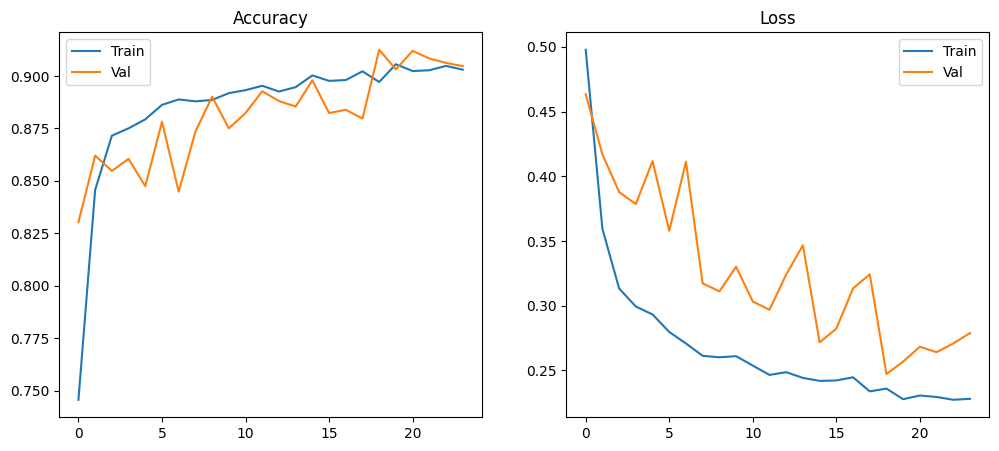

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_ex1.history['accuracy'])
plt.plot(history_ex1.history['val_accuracy'])
plt.legend(['Train','Val'])
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_ex1.history['loss'])
plt.plot(history_ex1.history['val_loss'])
plt.legend(['Train','Val'])
plt.title('Loss')

plt.show()

_____________________________________________________________________________________________________________________________________________

# =====================================================
# 2.2 EXPERIMENT 2 -  IMPROVED MODEL (Vanella CNN).
# =====================================================

In [31]:

image_size = (150,150,3)

model_2 = Sequential()
model_2.add(Conv2D(64, (3,3), strides=(1, 1), padding='same', activation="relu", input_shape=image_size))
model_2.add(MaxPooling2D())

model_2.add(Conv2D(128, (3,3), strides=(1, 1), padding='same', activation="relu"))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.2))

model_2.add(Conv2D(256, (3,3), strides=(1, 1), padding='same', activation="relu"))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.2))

model_2.add(Conv2D(512, (3,3), strides=(1, 1), padding='same', activation="relu"))
model_2.add(MaxPooling2D())
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(128, activation="relu"))
model_2.add(Dropout(0.15))

model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])

model_2.summary()



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,859,649 (26.17 MB)

 Trainable params: 6,859,649 (26.17 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_ex2_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [33]:
history_ex2 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks_list
)


Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9055 - loss: 0.2126
Epoch 1: val_accuracy improved from -inf to 0.90578, saving model to best_cnn_ex2_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 111s 459ms/step - accuracy: 0.9055 - loss: 0.2127 - val_accuracy: 0.9058 - val_loss: 0.2565 - learning_rate: 2.0000e-05
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9161 - loss: 0.2018
Epoch 2: val_accuracy improved from 0.90578 to 0.90786, saving model to best_cnn_ex2_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 421ms/step - accuracy: 0.9161 - loss: 0.2019 - val_accuracy: 0.9079 - val_loss: 0.2641 - learning_rate: 2.0000e-05
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9122 - loss: 0.2074
Epoch 3: val_accuracy did not improve from 0.90786
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 420ms/step - accuracy: 0.9122 - loss: 0.2074 - val_accuracy: 0.9068 - val_loss: 0.2805 - learning_rate: 2.0000e-05
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9087 - loss: 0.2116
Epoch 4: val_accuracy did not improve from 0.90786
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 417ms/step - accuracy: 0.9087 - loss: 0.2116 - val_accuracy: 0.9073 - val_loss: 0.2534 - learning_rate: 2.0000e-05
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9084 - loss: 0.2147
Epoch 5: val_accuracy improved from 0.90786 to 0.91255, saving model to best_cnn_ex2_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 421ms/step - accuracy: 0.9084 - loss: 0.2147 - val_accuracy: 0.9125 - val_loss: 0.2476 - learning_rate: 2.0000e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9125 - loss: 0.2057
Epoch 6: val_accuracy improved from 0.91255 to 0.91307, saving model to best_cnn_ex2_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 420ms/step - accuracy: 0.9125 - loss: 0.2057 - val_accuracy: 0.9131 - val_loss: 0.2400 - learning_rate: 2.0000e-05
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9135 - loss: 0.2096
Epoch 7: val_accuracy did not improve from 0.91307
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 419ms/step - accuracy: 0.9135 - loss: 0.2096 - val_accuracy: 0.9120 - val_loss: 0.2489 - learning_rate: 2.0000e-05
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9092 - loss: 0.2135
Epoch 8: val_accuracy did not improve from 0.91307
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.9092 - loss: 0.2135 - val_accuracy: 0.9120 - val_loss: 0.2371 - learning_rate: 2.0000e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9111 - loss: 0.2044
Epoch 9: val_accuracy did not improve from 0.91307
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.9111 - loss: 0.2044 - val_accuracy: 0.9094 - val_loss: 0.2410 - learning_rate

241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 427ms/step - accuracy: 0.9121 - loss: 0.2132 - val_accuracy: 0.9204 - val_loss: 0.2348 - learning_rate: 2.0000e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9130 - loss: 0.2017
Epoch 11: val_accuracy did not improve from 0.92035
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 426ms/step - accuracy: 0.9131 - loss: 0.2017 - val_accuracy: 0.9094 - val_loss: 0.2542 - learning_rate: 2.0000e-05
Epoch 12/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9132 - loss: 0.2109
Epoch 12: val_accuracy did not improve from 0.92035
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.9132 - loss: 0.2108 - val_accuracy: 0.9110 - val_loss: 0.2455 - learning_rate: 2.0000e-05
Epoch 13/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9169 - loss: 0.1975
Epoch 13: val_accuracy did not improve from 0.92035
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 420ms/step - accuracy: 0.9169 - loss: 0.1976 - val_accuracy: 0.9027 - val_loss: 0.2505 - learnin

In [39]:
train_acc = history_ex2.history['accuracy']
train_loss = history_ex2.history['loss']

val_acc = history_ex2.history['val_accuracy']
val_loss = history_ex2.history['val_loss']


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
 
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

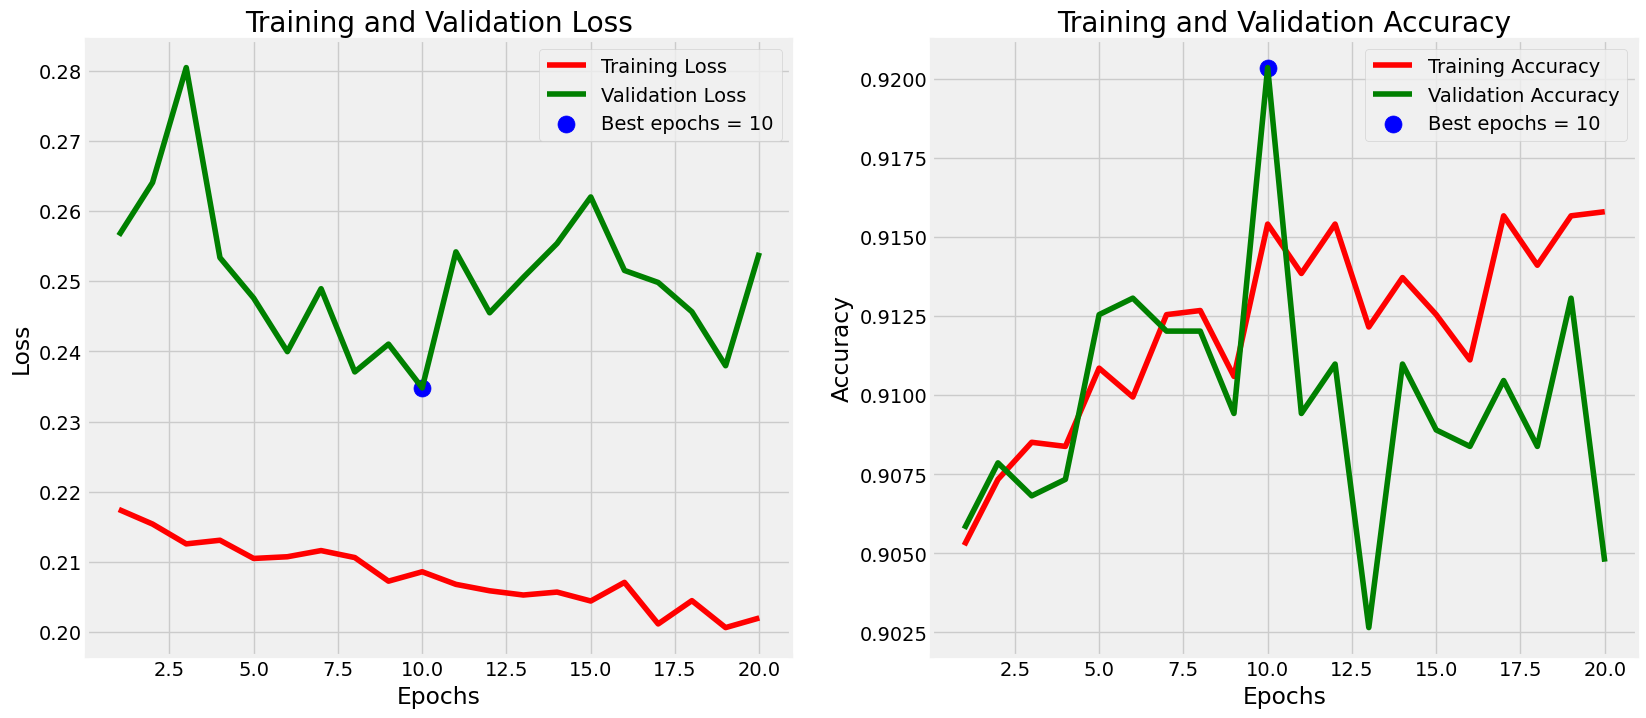

In [40]:


#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

✅ Using dataset path: /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train
Found 9605 images belonging to 2 classes.
Predicting...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step


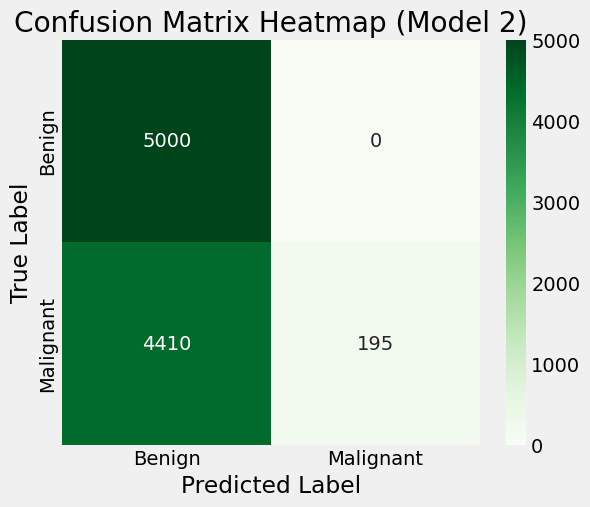

              precision    recall  f1-score   support

      Benign       0.53      1.00      0.69      5000
   Malignant       1.00      0.04      0.08      4605

    accuracy                           0.54      9605
   macro avg       0.77      0.52      0.39      9605
weighted avg       0.76      0.54      0.40      9605



In [69]:

# ========================================================
# 1️⃣ SMART SETUP (Fixing the Path & Size automatically)
# ========================================================

# Get the correct path from your existing generator
# (Since val_generator works, we copy its path)
correct_path = val_generator.directory
print(f"✅ Using dataset path: {correct_path}")

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the temporary generator with the CORRECT path and size (150x150)
temp_generator = test_datagen.flow_from_directory(
    correct_path,            # <--- Using the detected path
    target_size=(150, 150),  # Fixed size for Model 2
    batch_size=32,
    class_mode='binary',
    shuffle=False            # Important: No shuffling
)

# ========================================================
# 2️⃣ PREDICT & PLOT
# ========================================================
# Get labels
true_labels = temp_generator.classes

# Predict using Model 2
print("Predicting...")
pred_probs = model_2.predict(temp_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int32")

# Plot Heatmap
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Benign','Malignant'],
            yticklabels=['Benign','Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap (Model 2)")
plt.show()

# Print Report
print(classification_report(true_labels, pred_labels, target_names=['Benign','Malignant']))

# =====================================================
# 3. EXPERIMENT 3 –   RETRAINED MODEL (MobileNetV2)
# =====================================================

In [45]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # Corrected to train_generator


# Load the MobileNetV2 model with pre-trained weights, excluding the top fully connected layers
base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# Freeze the base model layers
base_model.trainable = False

# Build the model
model_3 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(512, activation='relu'),  # Add a dense layer
    Dropout(0.5),  # Add dropout for regularization
    Dense(class_count, activation='sigmoid')  # Output layer for binary classification (benign vs malignant)
])

In [46]:
# Compile the model
model_3.compile(optimizer='adam',
              loss=' binary_crossentropy',  
              metrics=['accuracy'],
              run_eagerly=True) 

# Print model summary
model_3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,002 (11.14 MB)

 Trainable params: 659,458 (2.52 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [50]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True,  
    verbose=1
)

history_ex3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping] )

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 112s 463ms/step - accuracy: 0.9134 - loss: 0.2053 - val_accuracy: 0.9047 - val_loss: 0.2516
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 423ms/step - accuracy: 0.9131 - loss: 0.2046 - val_accuracy: 0.9115 - val_loss: 0.2397
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 427ms/step - accuracy: 0.9120 - loss: 0.2037 - val_accuracy: 0.9089 - val_loss: 0.2564
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 424ms/step - accuracy: 0.9075 - loss: 0.2126 - val_accuracy: 0.9167 - val_loss: 0.2384
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 421ms/step - accuracy: 0.9140 - loss: 0.2063 - val_accuracy: 0.9053 - val_loss: 0.2470
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.9168 - loss: 0.1952 - val_accuracy: 0.9089 - val_loss: 0.2507
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 102s 422ms/step - accuracy: 0.9103 - loss: 0.2099 - val_accuracy: 0.9110 - val_loss: 0.2514
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 101s 418ms/step - accuracy: 0.9188 -

In [53]:
model_3.save('/kaggle/working/MobileNetV2_model.h5')
print("Model saved successfully!")

Model saved successfully!


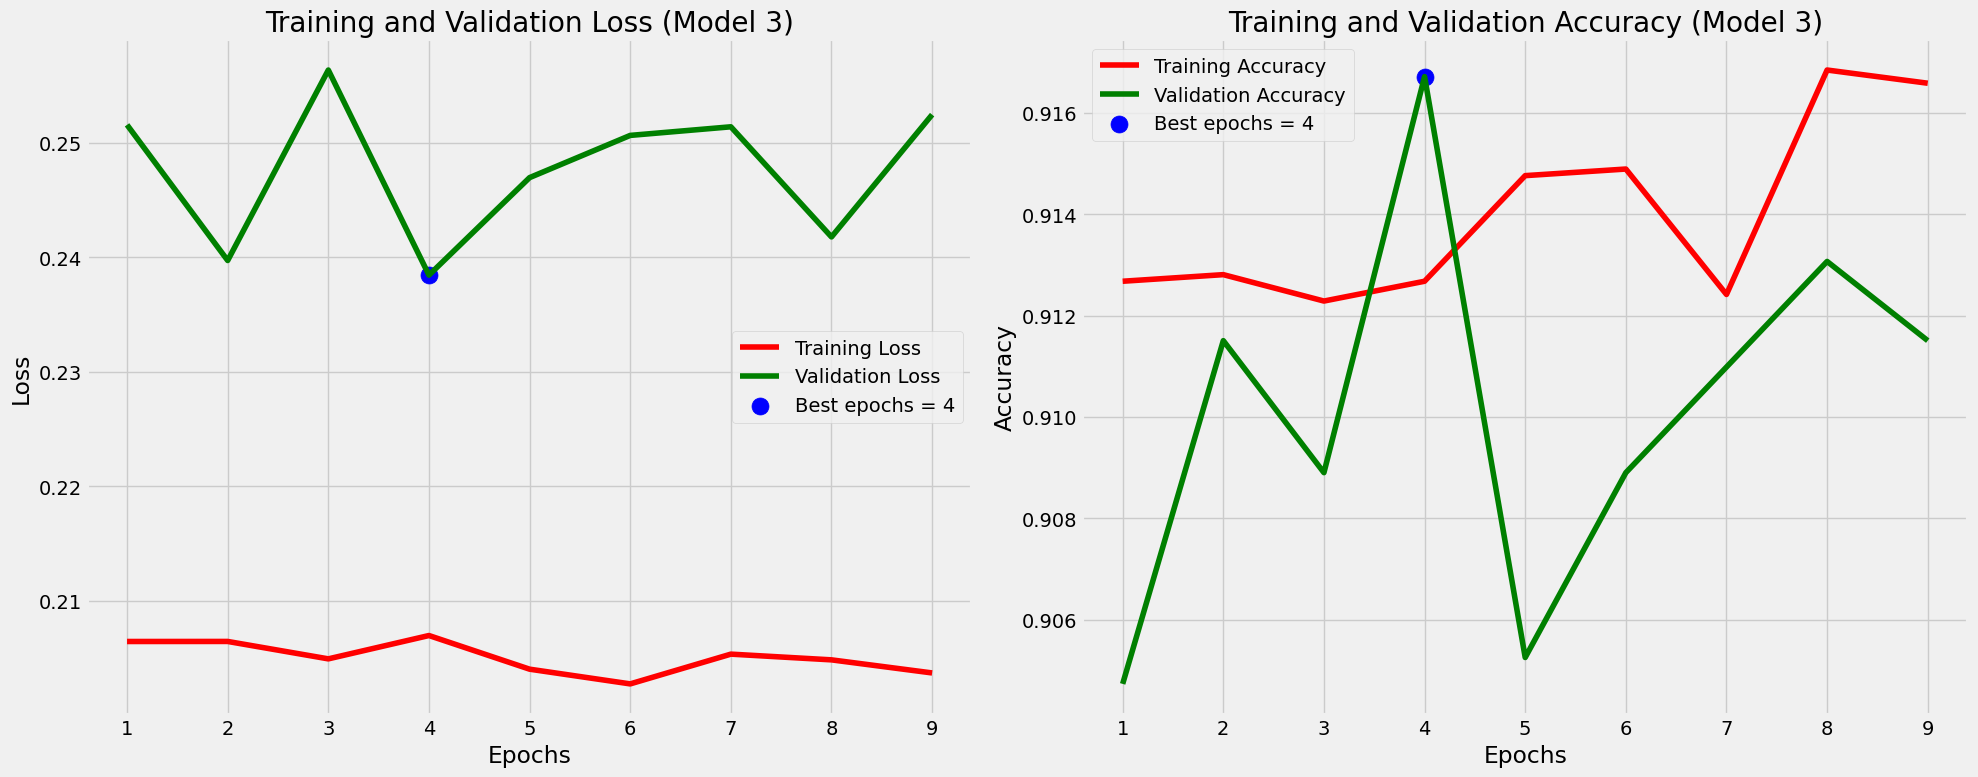

In [54]:
import matplotlib.pyplot as plt
import numpy as np


train_acc = history_ex3.history['accuracy']
train_loss = history_ex3.history['loss']

val_acc = history_ex3.history['val_accuracy']
val_loss = history_ex3.history['val_loss']

# حساب أفضل Epoch
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue', label = loss_label)
plt.title('Training and Validation Loss (Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue', label = acc_label)
plt.title('Training and Validation Accuracy (Model 3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Generating predictions...
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step

✅ Model Accuracy: 53.05%

📊 Classification Report:
              precision    recall  f1-score   support

      benign       0.53      0.98      0.68      1000
   malignant       0.64      0.05      0.09       921

    accuracy                           0.53      1921
   macro avg       0.58      0.51      0.39      1921
weighted avg       0.58      0.53      0.40      1921



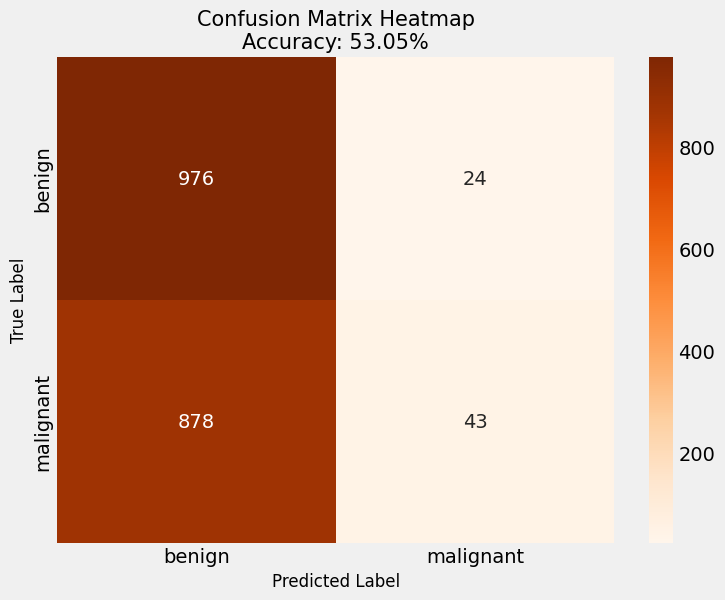

In [61]:

# Reset generator to ensure alignment
val_generator.reset()

# Get Class Names
class_names = list(val_generator.class_indices.keys())

# Make Predictions using model_3
print("Generating predictions...")
y_pred_probs = model_3.predict(val_generator, verbose=1)

# Handle Binary (Sigmoid) vs Multi-class (Softmax)
if y_pred_probs.shape[1] == 1:
    # Binary Classification (Sigmoid)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
else:
    # Multi-class Classification (Softmax)
    y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels
y_true = val_generator.classes

# 2️⃣ Calculate Metrics 
# ------------------------------------------------
# Calculate Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Model Accuracy: {accuracy * 100:.2f}%")

# Print Detailed Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3️⃣ Plot Confusion Matrix as Heatmap 
# ------------------------------------------------
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 14}) # Font size for numbers

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix Heatmap\nAccuracy: {accuracy*100:.2f}%', fontsize=15)
plt.show()